In [1]:
import numpy as np
import pandas as pd
import category_encoders as ce
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
import joblib 
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.calibration import CalibratedClassifierCV
from sklearn import preprocessing
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import class_weight
from xgboost.sklearn import XGBClassifier
import warnings
warnings.filterwarnings("ignore")

In [2]:
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [3]:
X1 = pd.read_csv('X1.csv')
Y1 = pd.read_csv('Y1.csv')
Y1 = Y1.squeeze()
dict_bf = joblib.load('dictfactor')
testfinal = pd.read_csv('test.csv')
enc = joblib.load('enc.pkl')
fitp = joblib.load('model.pkl')
scaler = joblib.load('scaler.pkl')

In [4]:
X1.head()

,LatestDegreeCGPA,YearsOfExperince,CurrentCTC,EmpScore,FitmentPercent,0_1,0_2,1_1,1_2,2_1,...,4_3,5_1,5_2,6_0,7_0,7_1,7_2,7_3,8_1,8_2
0,-0.074458,1.591065,0.405536,1.539209,0.9369,0,1,0,1,0,...,1,0,1,0,0,0,0,1,0,1
1,-0.074458,-1.035296,-0.426888,1.539209,0.6709,0,1,0,1,0,...,0,1,0,0,0,0,1,0,1,0
2,-0.817130,-0.159842,-0.426888,1.539209,0.9126,0,1,1,0,0,...,1,0,1,1,0,0,1,1,1,0
3,-1.559802,-0.159842,-0.288151,1.539209,0.7229,0,1,1,0,0,...,0,1,1,0,0,0,1,1,1,1
4,0.668214,-1.327114,0.821748,1.539209,0.8634,0,1,0,1,0,...,1,1,0,0,0,0,1,1,0,1


In [5]:
X1.shape

(13645, 29)

In [6]:
train, test, ytrain, ytest = train_test_split(X1, Y1, test_size = 0.2, random_state = 42)
train.shape, test.shape

((10916, 29), (2729, 29))

In [7]:
dict_bf

{9: 'YearsOfExperince',
 8: 'None',
 4: 'Gender',
 1: 'DegreeBranch',
 0: 'CurrentCompanyType',
 7: 'MartialStatus',
 5: 'HighestDegree',
 2: 'EmpScore',
 3: 'Ethinicity',
 6: 'LatestDegreeCGPA'}

In [8]:
def CreateBalancedSampleWeights(ytrain, largest_class_weight_coef):
    
    classes = ytrain.unique()
    classes.sort()
    class_samples = np.bincount(ytrain)
    total_samples = class_samples.sum()
    n_classes = len(class_samples)
    weights = total_samples / (n_classes * class_samples * 1.0)
    class_weight_dict = {key : value for (key, value) in zip(classes, weights)}
    class_weight_dict[classes[1]] = class_weight_dict[classes[1]] * largest_class_weight_coef
    sample_weights = [class_weight_dict[y] for y in ytrain]
    return sample_weights

In [9]:
train_sample_weight = CreateBalancedSampleWeights(ytrain, largest_class_weight_coef=1)

In [10]:
train.columns

Index(['LatestDegreeCGPA', 'YearsOfExperince', 'CurrentCTC', 'EmpScore',
       'FitmentPercent', '0_1', '0_2', '1_1', '1_2', '2_1', '2_2', '2_3',
       '2_4', '3_0', '3_1', '3_2', '3_3', '4_1', '4_2', '4_3', '5_1', '5_2',
       '6_0', '7_0', '7_1', '7_2', '7_3', '8_1', '8_2'],
      dtype='object')

In [11]:
xgb = XGBClassifier(learning_rate=0.1,
                    n_estimators=600,
                    max_depth=4,
                    min_child_weight=1,
                    reg_alpha=0.01,
                    gamma=0,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    objective='multi:softmax',
                    nthread=4,
                    num_class=10)

model = xgb.fit(train, ytrain, sample_weight=train_sample_weight)
calibrated = CalibratedClassifierCV(model, method='sigmoid', cv=5)
calibrated.fit(train, ytrain)
ypred = calibrated.predict(test)

[19:28:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:28:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:29:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:29:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

In [12]:
#grid_search = GridSearchCV(xgb, n_jobs=-1, param_grid = param_dist, cv = 3, scoring="roc_auc", verbose=5)
#grid_search.fit(train, ytrain)
#grid_search.best_estimator_

In [13]:
#rf_random.best_params_

In [14]:
print(classification_report(ytest, ypred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       235
           1       0.93      0.99      0.96       537
           2       0.79      0.91      0.84       128
           3       0.30      0.10      0.15        70
           4       1.00      1.00      1.00       552
           5       1.00      1.00      1.00       103
           6       1.00      0.92      0.96        53
           7       0.83      0.70      0.76        56
           8       0.96      0.98      0.97       658
           9       1.00      1.00      1.00       337

    accuracy                           0.96      2729
   macro avg       0.88      0.86      0.86      2729
weighted avg       0.95      0.96      0.95      2729



In [15]:
feature_importances = pd.DataFrame(model.feature_importances_,index = train.columns,columns = ['importance']).sort_values('importance',ascending = False)
feature_importances

,importance
1_2,0.251349
8_1,0.133214
1_1,0.104239
3_3,0.068721
4_3,0.067926
EmpScore,0.056805
LatestDegreeCGPA,0.046592
3_2,0.040333
3_1,0.032809
YearsOfExperince,0.030445


In [16]:
ytest = ytest.reset_index(drop=True)

In [17]:
out = pd.DataFrame()
out['pred'] = ypred
out['pred'] = out['pred'].map(dict_bf)
out['observed'] = ytest
out['observed'] = out['observed'].map(dict_bf)
out['flag'] = np.where(out['pred'] == out['observed'], 1, 0)

In [18]:
df = out[['observed','flag']].groupby('observed').agg(['count','sum']).reset_index()
df['%'] = df[('flag', 'sum')] / df[('flag', 'count')] * 100
df

observed  flag                %
                      count  sum            
0  CurrentCompanyType   235  232   98.723404
1        DegreeBranch   537  529   98.510242
2            EmpScore   128  117   91.406250
3          Ethinicity    70    7   10.000000
4              Gender   552  552  100.000000
5       HighestDegree   103  103  100.000000
6    LatestDegreeCGPA    53   49   92.452830
7       MartialStatus    56   39   69.642857
8                None   658  643   97.720365
9    YearsOfExperince   337  337  100.000000

In [19]:
testfinal['DegreeBranch'] = np.where((testfinal['HighestDegree'].isin(['BCA', 'MCA'])) & (testfinal['DegreeBranch'].isin(['Electrical', 'Electronics', 'Electrical and Electronics'])), 'Computer Science', testfinal['DegreeBranch'])
testfinal.head()

,EmpID,EmpName,LanguageOfCommunication,Age,Gender,JobProfileIDApplyingFor,HighestDegree,DegreeBranch,GraduatingInstitute,LatestDegreeCGPA,YearsOfExperince,GraduationYear,CurrentCTC,ExpectedCTC,MartialStatus,EmpScore,CurrentDesignation,CurrentCompanyType,DepartmentInCompany,TotalLeavesTaken
0,5664,Theo,Native,35,Male,JR85289,PhD,Information Technology,Tier 2,5,5,2016,27,34,Single,4,SDE,Enterprise,Finance,18
1,23568,Vernie,English,35,Male,JR85289,B.Tech,Information Technology,Tier 3,9,12,2009,29,33,Married,4,EM,Enterprise,Engineering,8
2,21490,Wendell,English,28,Male,JR87525,M.Tech,Artificial Intelligence,Tier 2,9,2,2019,18,25,Married,3,SDE,Startup,Engineering,18
3,8363,West,Hindi,37,Male,JR87525,MS,Computer Science,Tier 2,8,11,2010,7,12,Single,5,DS,Enterprise,Product,17
4,6165,Alford,Hindi,36,Female,JR85289,PhD,Artificial Intelligence,Tier 2,7,6,2015,22,32,Married,4,SDE,Startup,Engineering,9


In [20]:
numeric_features = ['YearsOfExperince', 'CurrentCTC', 'EmpScore', 'LatestDegreeCGPA']

In [21]:
## standardize the numeric features.
scaled = scaler.fit_transform(testfinal[numeric_features])

for i, col in enumerate(numeric_features):
      testfinal[col] = scaled[:,i]

In [22]:
categorical = ['LanguageOfCommunication', 'Gender', 'JobProfileIDApplyingFor', 
               'HighestDegree', 'DegreeBranch', 'GraduatingInstitute', 'MartialStatus', 
               'CurrentDesignation', 'CurrentCompanyType']

In [23]:
dfbin = enc.transform(testfinal[categorical].values)
testfinal = pd.concat([testfinal, dfbin], axis = 1)

In [24]:
X = testfinal[['YearsOfExperince', 'CurrentCTC', 'EmpScore', 
               '0_1', '0_2', '1_1', '1_2', '2_1', '2_2', '2_3', 
               '2_4', '3_0', '3_1', '3_2', '3_3', '4_1', '4_2', 
               '4_3', '5_1', '5_2', '6_0','7_0', '7_1', '7_2',
               '7_3', '8_1', '8_2']]

In [25]:
X

,YearsOfExperince,CurrentCTC,EmpScore,0_1,0_2,1_1,1_2,2_1,2_2,2_3,...,4_3,5_1,5_2,6_0,7_0,7_1,7_2,7_3,8_1,8_2
0,-0.423565,1.255399,0.578591,1,0,0,1,0,0,0,...,0,1,1,1,0,0,1,1,0,1
1,1.600836,1.534977,0.578591,0,1,0,1,0,0,0,...,0,1,0,0,0,1,0,1,0,1
2,-1.291166,-0.002701,-0.367162,0,1,0,1,0,0,1,...,0,1,1,0,0,0,1,1,1,1
3,1.311636,-1.540380,1.524343,1,1,0,1,0,0,1,...,1,1,1,1,0,1,0,0,0,1
4,-0.134365,0.556454,0.578591,1,1,1,0,0,0,0,...,0,1,1,0,0,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8740,-1.001965,1.534977,1.524343,0,1,1,0,0,0,0,...,1,0,1,0,0,0,1,1,1,1
8741,-1.580366,-0.002701,0.578591,1,1,0,1,0,0,0,...,1,0,1,0,0,0,1,0,1,1
8742,-0.712765,-1.540380,0.578591,0,1,0,1,0,0,0,...,1,1,1,0,0,0,1,1,1,1
8743,0.154835,-1.400591,0.578591,0,1,0,1,1,0,0,...,0,0,1,0,0,0,0,1,0,1


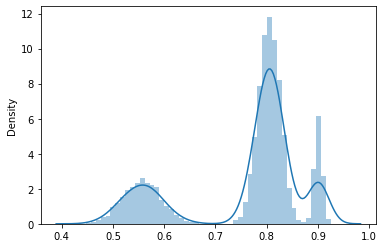

In [26]:
pred_X = fitp.predict(X)
sns.distplot(pred_X)

In [27]:
testfinal['FitmentPercent'] = np.round(pred_X * 100,2)

In [28]:
X1.columns

Index(['LatestDegreeCGPA', 'YearsOfExperince', 'CurrentCTC', 'EmpScore',
       'FitmentPercent', '0_1', '0_2', '1_1', '1_2', '2_1', '2_2', '2_3',
       '2_4', '3_0', '3_1', '3_2', '3_3', '4_1', '4_2', '4_3', '5_1', '5_2',
       '6_0', '7_0', '7_1', '7_2', '7_3', '8_1', '8_2'],
      dtype='object')

In [29]:
#testfinal = pd.read_csv('gmm.csv')
#testfinal['FitmentPercent'] = testfinal['FitmentPercent'] * 100
X1 = testfinal[['LatestDegreeCGPA', 'YearsOfExperince', 'CurrentCTC', 'EmpScore', 'FitmentPercent', 
                '0_1', '0_2', '1_1', '1_2', '2_1', '2_2', '2_3', '2_4', '3_0', '3_1', '3_2', '3_3',
                '4_1', '4_2', '4_3', '5_1', '5_2', '6_0', '7_0', '7_1', '7_2', '7_3', '8_1', '8_2']]

In [30]:
X1.describe()

,LatestDegreeCGPA,YearsOfExperince,CurrentCTC,EmpScore,FitmentPercent,0_1,0_2,1_1,1_2,2_1,...,4_3,5_1,5_2,6_0,7_0,7_1,7_2,7_3,8_1,8_2
count,8.745000e+03,8.745000e+03,8.745000e+03,8.745000e+03,8745.000000,8745.000000,8745.000000,8745.000000,8745.000000,8745.000000,...,8745.000000,8745.000000,8745.000000,8745.000000,8745.000000,8745.000000,8745.000000,8745.000000,8745.000000,8745.000000
mean,8.206383e-17,9.587655e-17,1.064392e-16,-1.795654e-16,75.751393,0.454431,0.898685,0.381933,0.691595,0.079817,...,0.597141,0.657519,0.803659,0.278788,0.010520,0.273070,0.545798,0.720297,0.682561,0.771527
std,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,11.881195,0.497948,0.301763,0.485888,0.461861,0.271025,...,0.490501,0.474567,0.397252,0.448429,0.102033,0.445562,0.497927,0.448879,0.465506,0.419873
min,-2.325110e+00,-1.580366e+00,-1.680169e+00,-2.258666e+00,44.740000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-8.305246e-01,-1.001965e+00,-8.414352e-01,-3.671617e-01,75.880000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,-8.323191e-02,-1.343648e-01,-2.701467e-03,-3.671617e-01,80.020000,0.000000,1.000000,0.000000,1.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
75%,6.640607e-01,7.332358e-01,8.360322e-01,5.785906e-01,82.300000,1.000000,1.000000,1.000000,1.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,2.158646e+00,1.600836e+00,1.674766e+00,1.524343e+00,92.490000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [31]:
ypred = xgb.predict(X1)
testfinal['BiasInfluentialFactor'] = ypred
testfinal['BiasInfluentialFactor'] = testfinal['BiasInfluentialFactor'].map(dict_bf)

In [32]:
testfinal['FitmentProb'] = pd.qcut(testfinal['FitmentPercent'], 10)
testfinal['FitmentProb'].value_counts()

(77.63, 79.07]                  880
(79.07, 80.02]                  879
(59.358, 77.63]                 876
(44.739000000000004, 54.984]    875
(82.95, 89.38]                  875
(54.984, 59.358]                874
(81.78, 82.95]                  873
(89.38, 92.49]                  873
(80.84, 81.78]                  871
(80.02, 80.84]                  869
Name: FitmentProb, dtype: int64

In [33]:
testfinal['BiasInfluentialFactor'].value_counts()

DegreeBranch          2837
Gender                1916
YearsOfExperince      1398
CurrentCompanyType     651
EmpScore               555
HighestDegree          536
MartialStatus          351
None                   295
Ethinicity             205
LatestDegreeCGPA         1
Name: BiasInfluentialFactor, dtype: int64

In [34]:
df = testfinal[['EmpID', 'FitmentProb', 'BiasInfluentialFactor']].groupby(['FitmentProb', 'BiasInfluentialFactor']).agg(['count']).reset_index()
df =  pd.pivot_table(df, values = 'EmpID', index = ['FitmentProb'], columns = ['BiasInfluentialFactor'], aggfunc = np.sum, fill_value = 0)
df['Total'] = df.sum(axis=1)
df

count                        \
BiasInfluentialFactor        CurrentCompanyType DegreeBranch EmpScore   
FitmentProb                                                             
(44.739000000000004, 54.984]                208          380       31   
(54.984, 59.358]                            231          388       15   
(59.358, 77.63]                              69          240       20   
(77.63, 79.07]                               12          186       19   
(79.07, 80.02]                                9          209       48   
(80.02, 80.84]                                9          239       40   
(80.84, 81.78]                                6          253       47   
(81.78, 82.95]                                3          254       62   
(82.95, 89.38]                               18          298       80   
(89.38, 92.49]                               86          390      193   

                                                                               \
BiasInfluentialFactor        Ethinicity Gender HighestDegree LatestDegreeCGPA   
FitmentProb                                                                     
(44.739000000000004, 54.984]         13      0            56                0   
(54.984, 59.358]                     10      0            54                0   
(59.358, 77.63]                      22    327            34                0   
(77.63, 79.07]                       16    387            38                1   
(79.07, 80.02]                       24    316            41                0   
(80.02, 80.84]                       39    258            49                0   
(80.84, 81.78]                       28    268            49                0   
(81.78, 82.95]                       22    207            59                0   
(82.95, 89.38]                       21    153            72                0   
(89.38, 92.49]                       10      0            84                0   

                                                                 Total  
BiasInfluentialFactor        MartialStatus None YearsOfExperince        
FitmentProb                                                             
(44.739000000000004, 54.984]            21   16              150   875  
(54.984, 59.358]                        26   14              136   874  
(59.358, 77.63]                         17   28              119   876  
(77.63, 79.07]                          27   39              155   880  
(79.07, 80.02]                          37   40              155   879  
(80.02, 80.84]                          49   44              142   869  
(80.84, 81.78]                          63   31              126   871  
(81.78, 82.95]                          58   56              152   873  
(82.95, 89.38]                          53   27              153   875  
(89.38, 92.49]                           0    0              110   873

In [35]:
testfinal['BiasInfluentialFactor'] = testfinal['BiasInfluentialFactor'].str.replace('None','')
testfinal[['EmpID', 'BiasInfluentialFactor', 'FitmentPercent']].to_csv('submission.csv',index=False)